In [7]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Change to your working directory
import os
os.chdir('/content')
print("Current directory:", os.getcwd())


Current directory: /content


In [9]:
# Download SMS Spam Collection Dataset
import os


if not os.path.exists('SMSSpamCollection'):
    print("Downloading dataset...")
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
    !unzip -o smsspamcollection.zip
    print("✓ Dataset downloaded and extracted!")
else:
    print("✓ Dataset already exists!")


!ls -lh SMSSpamCollection

--2025-11-24 20:58:58--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z     [ <=>                ] 198.65K  1.09MB/s    in 0.2s    

2025-11-24 20:58:59 (1.09 MB/s) - ‘smsspamcollection.zip’ saved [203415]

Archive:  smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  
✓ Dataset downloaded and extracted!
-rw-r--r-- 1 root root 467K Mar 15  2011 SMSSpamCollection


In [10]:
# Install libraries (most are pre-installed in Colab, but let's ensure)
!pip install scikit-learn pandas matplotlib seaborn nltk -q

print("✓ All libraries installed!")


✓ All libraries installed!


In [11]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("✓ Libraries imported successfully!")


✓ Libraries imported successfully!


In [12]:
# Load SMS Spam Collection dataset
# The file is tab-separated with no headers

df = pd.read_csv('SMSSpamCollection',
                 sep='\t',                    # Tab-separated
                 names=['label', 'message'],  # Column names
                 encoding='latin-1')          # Encoding for special characters

print("✓ Dataset loaded successfully!")
print(f"Total messages: {len(df)}")
print("\nFirst 3 rows:")
print(df.head(3))


✓ Dataset loaded successfully!
Total messages: 5572

First 3 rows:
  label  \
0   ham   
1   ham   
2  spam   

                                                                                               message  
0  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...  
1                                                                        Ok lar... Joking wif u oni...  
2  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...  


In [13]:
# Convert 'ham' and 'spam' to 0 and 1 for machine learning
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

print("Label conversion:")
print(df['label'].value_counts())
print("\nSample data after conversion:")
print(df.head())


Label conversion:
label
0    4825
1     747
Name: count, dtype: int64

Sample data after conversion:
   label  \
0      0   
1      0   
2      1   
3      0   
4      0   

                                                                                               message  
0  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...  
1                                                                        Ok lar... Joking wif u oni...  
2  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...  
3                                                    U dun say so early hor... U c already then say...  
4                                        Nah I don't think he goes to usf, he lives around here though  


In [14]:
# Import NLTK (Natural Language Toolkit)
import nltk

# Download required NLTK data files
print("Downloading NLTK data...")
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

print("✓ NLTK data downloaded!")

# Import stopwords
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Check available stopwords
stop_words = set(stopwords.words('english'))
print(f"\nTotal stopwords: {len(stop_words)}")
print(f"Sample stopwords: {list(stop_words)[:10]}")


✓ NLTK data downloaded!

Total stopwords: 198
Sample stopwords: ['most', 'doing', 'me', 'where', 'her', 'than', 'being', "we'll", "don't", 'and']


In [15]:
# Look at some raw messages before cleaning
print("SAMPLE RAW MESSAGES:")
print("="*70)

print("\n--- SPAM Message 1 ---")
print(df[df['label'] == 1]['message'].iloc[0])

print("\n--- SPAM Message 2 ---")
print(df[df['label'] == 1]['message'].iloc[1])

print("\n--- HAM Message 1 ---")
print(df[df['label'] == 0]['message'].iloc[0])

print("\n--- HAM Message 2 ---")
print(df[df['label'] == 0]['message'].iloc[1])


SAMPLE RAW MESSAGES:

--- SPAM Message 1 ---
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

--- SPAM Message 2 ---
FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv

--- HAM Message 1 ---
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

--- HAM Message 2 ---
Ok lar... Joking wif u oni...


In [16]:
def clean_text_basic(text):
    """
    Basic text cleaning function

    Steps:
    1. Convert to lowercase
    2. Remove special characters and numbers
    3. Remove extra whitespace

    Args:
        text (str): Input text message

    Returns:
        str: Cleaned text
    """
    # Step 1: Convert to lowercase
    text = text.lower()

    # Step 2: Remove special characters, numbers, and punctuation
    # Keep only alphabets and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Step 3: Remove extra whitespace
    text = ' '.join(text.split())

    return text

# Test the function
test_message = "WINNER!! You've won $1000! Call 123-456-7890 NOW!!! Visit www.spam.com"
print("Original Message:")
print(test_message)
print("\nCleaned Message:")
print(clean_text_basic(test_message))


Original Message:
WINNER!! You've won $1000! Call 123-456-7890 NOW!!! Visit www.spam.com

Cleaned Message:
winner youve won call now visit wwwspamcom


In [17]:
# Apply cleaning function to all messages
print("Cleaning all messages... This may take a minute...")

df['cleaned_message'] = df['message'].apply(clean_text_basic)

print("✓ Cleaning complete!")
print(f"Total messages cleaned: {len(df)}")

# Show comparison for first few messages
print("\n" + "="*70)
print("COMPARISON: Original vs Cleaned Messages")
print("="*70)

for i in range(3):
    print(f"\n--- Message {i+1} ---")
    print(f"Label: {'SPAM' if df['label'].iloc[i] == 1 else 'HAM'}")
    print(f"Original: {df['message'].iloc[i][:80]}...")
    print(f"Cleaned:  {df['cleaned_message'].iloc[i][:80]}...")


Cleaning all messages... This may take a minute...
✓ Cleaning complete!
Total messages cleaned: 5572

COMPARISON: Original vs Cleaned Messages

--- Message 1 ---
Label: HAM
Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet...
Cleaned:  go until jurong point crazy available only in bugis n great world la e buffet ci...

--- Message 2 ---
Label: HAM
Original: Ok lar... Joking wif u oni......
Cleaned:  ok lar joking wif u oni...

--- Message 3 ---
Label: SPAM
Original: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 8...
Cleaned:  free entry in a wkly comp to win fa cup final tkts st may text fa to to receive ...


Message Length Statistics:

Original Messages:
count    5572.000000
mean       80.616296
std        60.015593
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: original_length, dtype: float64

Cleaned Messages:
count    5572.000000
mean       72.977387
std        54.234873
min         0.000000
25%        33.000000
50%        57.000000
75%       109.000000
max       888.000000
Name: cleaned_length, dtype: float64


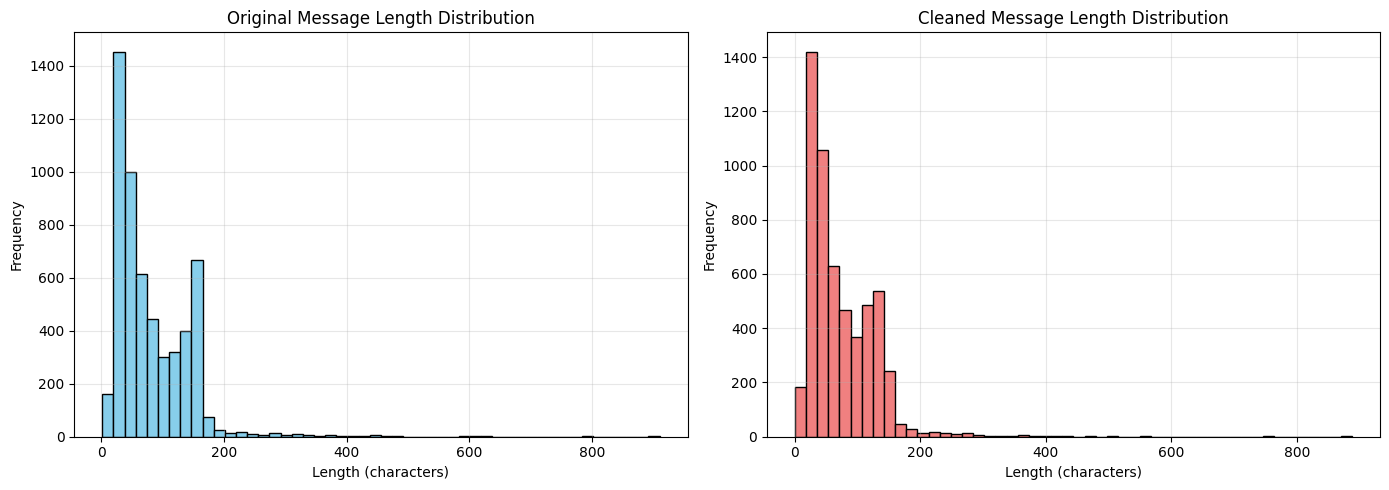


✓ Chart saved as 'message_length_comparison.png'


In [18]:
# Calculate message lengths
df['original_length'] = df['message'].apply(len)
df['cleaned_length'] = df['cleaned_message'].apply(len)

print("Message Length Statistics:")
print("="*50)
print("\nOriginal Messages:")
print(df['original_length'].describe())
print("\nCleaned Messages:")
print(df['cleaned_length'].describe())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original length distribution
axes[0].hist(df['original_length'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Original Message Length Distribution')
axes[0].set_xlabel('Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# Cleaned length distribution
axes[1].hist(df['cleaned_length'], bins=50, color='lightcoral', edgecolor='black')
axes[1].set_title('Cleaned Message Length Distribution')
axes[1].set_xlabel('Length (characters)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('message_length_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Chart saved as 'message_length_comparison.png'")


In [19]:
def remove_stopwords(text):
    """
    Remove common English stopwords

    Stopwords are common words like: the, is, are, and, etc.
    that don't add much meaning for classification

    Args:
        text (str): Input text (already cleaned)

    Returns:
        str: Text with stopwords removed
    """
    # Get stopwords
    stop_words = set(stopwords.words('english'))

    # Split text into words
    words = text.split()

    # Keep only words that are NOT stopwords
    filtered_words = [word for word in words if word not in stop_words]

    # Join words back into string
    return ' '.join(filtered_words)

# Create version without stopwords
print("Removing stopwords...")
df['cleaned_no_stopwords'] = df['cleaned_message'].apply(remove_stopwords)
print("✓ Stopwords removed!")

# Compare
print("\n" + "="*70)
print("COMPARISON: With Stopwords vs Without Stopwords")
print("="*70)

for i in range(2):
    print(f"\n--- Message {i+1} ---")
    print(f"With stopwords:    {df['cleaned_message'].iloc[i]}")
    print(f"Without stopwords: {df['cleaned_no_stopwords'].iloc[i]}")


Removing stopwords...
✓ Stopwords removed!

COMPARISON: With Stopwords vs Without Stopwords

--- Message 1 ---
With stopwords:    go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
Without stopwords: go jurong point crazy available bugis n great world la e buffet cine got amore wat

--- Message 2 ---
With stopwords:    ok lar joking wif u oni
Without stopwords: ok lar joking wif u oni


In [20]:
# For spam detection, keeping stopwords often works better
# because patterns like "call now" or "click here" are important

# We'll use the version WITH stopwords for our features
X_text = df['cleaned_message']  # This is what we'll use

print("Decision: Using cleaned messages WITH stopwords")
print(f"Total messages ready for feature extraction: {len(X_text)}")

# Show a few examples
print("\n" + "="*70)
print("FINAL CLEANED MESSAGES (Ready for Feature Extraction)")
print("="*70)
for i in range(3):
    print(f"\n{i+1}. [{df['label'].iloc[i]}] {X_text.iloc[i][:100]}...")


Decision: Using cleaned messages WITH stopwords
Total messages ready for feature extraction: 5572

FINAL CLEANED MESSAGES (Ready for Feature Extraction)

1. [0] go until jurong point crazy available only in bugis n great world la e buffet cine there got amore w...

2. [0] ok lar joking wif u oni...

3. [1] free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry questionstd tx...


In [21]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Prepare X (features) and y (labels)
X = df['cleaned_message']  # Text data
y = df['label']            # Labels (0=ham, 1=spam)

print("Total dataset:")
print(f"Messages: {len(X)}")
print(f"Spam: {sum(y == 1)} ({sum(y == 1)/len(y)*100:.1f}%)")
print(f"Ham: {sum(y == 0)} ({sum(y == 0)/len(y)*100:.1f}%)")

# Split into training and testing sets
# 80% training, 20% testing
# stratify=y ensures spam/ham ratio is same in both sets
# random_state=42 ensures reproducible results

X_train, X_test, y_train, y_test = train_test_split(
    X,                  # Messages
    y,                  # Labels
    test_size=0.2,      # 20% for testing
    random_state=42,    # For reproducibility
    stratify=y          # Maintain spam/ham ratio
)

print("\n" + "="*70)
print("TRAIN-TEST SPLIT COMPLETE")
print("="*70)
print(f"\nTraining set: {len(X_train)} messages ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Spam: {sum(y_train == 1)} ({sum(y_train == 1)/len(y_train)*100:.1f}%)")
print(f"  Ham: {sum(y_train == 0)} ({sum(y_train == 0)/len(y_train)*100:.1f}%)")

print(f"\nTest set: {len(X_test)} messages ({len(X_test)/len(X)*100:.1f}%)")
print(f"  Spam: {sum(y_test == 1)} ({sum(y_test == 1)/len(y_test)*100:.1f}%)")
print(f"  Ham: {sum(y_test == 0)} ({sum(y_test == 0)/len(y_test)*100:.1f}%)")


Total dataset:
Messages: 5572
Spam: 747 (13.4%)
Ham: 4825 (86.6%)

TRAIN-TEST SPLIT COMPLETE

Training set: 4457 messages (80.0%)
  Spam: 598 (13.4%)
  Ham: 3859 (86.6%)

Test set: 1115 messages (20.0%)
  Spam: 149 (13.4%)
  Ham: 966 (86.6%)


In [22]:
# Show some examples from training set
print("SAMPLE TRAINING DATA:")
print("="*70)

train_df = pd.DataFrame({
    'label': y_train.values[:5],
    'message': X_train.values[:5]
})

for idx, row in train_df.iterrows():
    label_text = "SPAM" if row['label'] == 1 else "HAM"
    print(f"\n{label_text}: {row['message'][:80]}...")


SAMPLE TRAINING DATA:

HAM: he will you guys close...

HAM: can i please come up now imin towndontmatter if urgoin outlrjust reallyneed docd...

HAM: ok ksry i knw sivatats y i askd...

HAM: ill see but prolly yeah...

HAM: ill see if i can swing by in a bit got some things to take care of here firsg...


In [23]:
# Bag of Words (BoW) converts text to numbers
# Each unique word becomes a feature (column)
# Each message becomes a row showing word counts

print("BAG OF WORDS EXAMPLE:")
print("="*70)

# Simple example
simple_messages = [
    "call now to win",
    "call me tonight",
    "win free money"
]

print("Original messages:")
for i, msg in enumerate(simple_messages, 1):
    print(f"{i}. {msg}")

# Create simple BoW representation manually
from collections import Counter

print("\nBag of Words representation:")
print("(Each row = message, each column = word count)")
print()

# Get all unique words
all_words = sorted(set(' '.join(simple_messages).split()))
print(f"Unique words: {all_words}")

# Create matrix
print("\nWord count matrix:")
print(f"{'Message':<20}", end="")
for word in all_words:
    print(f"{word:>8}", end="")
print()
print("-" * 70)

for msg in simple_messages:
    words_in_msg = msg.split()
    counts = Counter(words_in_msg)
    print(f"{msg:<20}", end="")
    for word in all_words:
        print(f"{counts[word]:>8}", end="")
    print()


BAG OF WORDS EXAMPLE:
Original messages:
1. call now to win
2. call me tonight
3. win free money

Bag of Words representation:
(Each row = message, each column = word count)

Unique words: ['call', 'free', 'me', 'money', 'now', 'to', 'tonight', 'win']

Word count matrix:
Message                 call    free      me   money     now      to tonight     win
----------------------------------------------------------------------
call now to win            1       0       0       0       1       1       0       1
call me tonight            1       0       1       0       0       0       1       0
win free money             0       1       0       1       0       0       0       1


In [24]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Create vectorizer
# max_features=3000 means keep only top 3000 most common words
# stop_words='english' removes common words
bow_vectorizer = CountVectorizer(
    max_features=3000,      # Keep top 3000 words
    stop_words='english',   # Remove stopwords
    lowercase=True,         # Convert to lowercase (already done, but ensures)
    min_df=2                # Word must appear in at least 2 documents
)

print("Creating Bag of Words features...")
print("This may take 30-60 seconds...")

# FIT on training data and TRANSFORM it
# fit() learns the vocabulary from training data
# transform() converts text to numbers
X_train_bow = bow_vectorizer.fit_transform(X_train)

# TRANSFORM test data (using vocabulary learned from training)
# IMPORTANT: Only fit on training, not on test!
X_test_bow = bow_vectorizer.transform(X_test)

print("\n✓ Bag of Words features created!")
print("="*70)
print(f"Training features shape: {X_train_bow.shape}")
print(f"  - Rows (messages): {X_train_bow.shape[0]}")
print(f"  - Columns (unique words): {X_train_bow.shape[1]}")
print(f"\nTest features shape: {X_test_bow.shape}")
print(f"  - Rows (messages): {X_test_bow.shape[0]}")
print(f"  - Columns (unique words): {X_test_bow.shape[1]}")


Creating Bag of Words features...
This may take 30-60 seconds...

✓ Bag of Words features created!
Training features shape: (4457, 3000)
  - Rows (messages): 4457
  - Columns (unique words): 3000

Test features shape: (1115, 3000)
  - Rows (messages): 1115
  - Columns (unique words): 3000


In [25]:
# Get the vocabulary (words)
vocabulary = bow_vectorizer.get_feature_names_out()

print("VOCABULARY INFORMATION:")
print("="*70)
print(f"Total unique words in vocabulary: {len(vocabulary)}")
print(f"\nFirst 20 words: {list(vocabulary[:20])}")
print(f"\nLast 20 words: {list(vocabulary[-20:])}")

# Check if certain spam-related words are in vocabulary
spam_words = ['free', 'win', 'prize', 'call', 'claim', 'urgent', 'click']
print("\nChecking for common spam words:")
for word in spam_words:
    if word in vocabulary:
        print(f"  ✓ '{word}' is in vocabulary")
    else:
        print(f"  ✗ '{word}' is NOT in vocabulary")


VOCABULARY INFORMATION:
Total unique words in vocabulary: 3000

First 20 words: ['aah', 'aathilove', 'aathiwhere', 'ability', 'abiola', 'abj', 'able', 'abt', 'abta', 'aburo', 'ac', 'acc', 'accept', 'access', 'accident', 'accidentally', 'accordingly', 'account', 'ache', 'action']

Last 20 words: ['yijue', 'ym', 'yo', 'yoga', 'yogasana', 'yor', 'youclean', 'youd', 'youll', 'youre', 'youve', 'yr', 'yrs', 'yummy', 'yun', 'yunny', 'yuo', 'yup', 'zed', 'zoe']

Checking for common spam words:
  ✓ 'free' is in vocabulary
  ✓ 'win' is in vocabulary
  ✓ 'prize' is in vocabulary
  ✗ 'call' is NOT in vocabulary
  ✓ 'claim' is in vocabulary
  ✓ 'urgent' is in vocabulary
  ✓ 'click' is in vocabulary


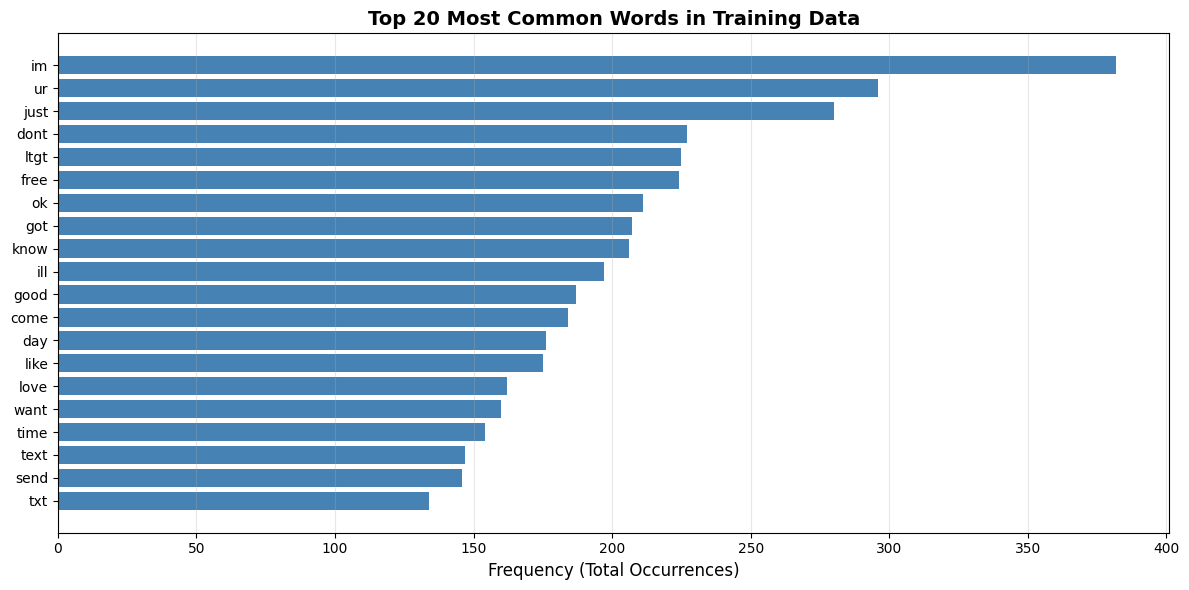


✓ Chart saved as 'top_words_bow.png'

Top 10 words:
word  frequency
  im        382
  ur        296
just        280
dont        227
ltgt        225
free        224
  ok        211
 got        207
know        206
 ill        197


In [26]:
# Calculate word frequencies across all training messages
word_freq = np.asarray(X_train_bow.sum(axis=0)).flatten()

# Create dataframe of words and their frequencies
word_freq_df = pd.DataFrame({
    'word': vocabulary,
    'frequency': word_freq
})

# Sort by frequency
word_freq_df = word_freq_df.sort_values('frequency', ascending=False)

# Plot top 20 words
plt.figure(figsize=(12, 6))
top_20 = word_freq_df.head(20)
plt.barh(range(len(top_20)), top_20['frequency'].values, color='steelblue')
plt.yticks(range(len(top_20)), top_20['word'].values)
plt.xlabel('Frequency (Total Occurrences)', fontsize=12)
plt.title('Top 20 Most Common Words in Training Data', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Highest at top
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('top_words_bow.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Chart saved as 'top_words_bow.png'")
print("\nTop 10 words:")
print(word_freq_df.head(10).to_string(index=False))


In [27]:
# TF-IDF = Term Frequency - Inverse Document Frequency
# It's smarter than Bag of Words because it considers:
# - TF: How often a word appears in a document (message)
# - IDF: How rare the word is across all documents

print("TF-IDF EXPLANATION:")
print("="*70)
print("""
TF-IDF gives higher weight to words that are:
1. Frequent in a specific message (TF - Term Frequency)
2. Rare across all messages (IDF - Inverse Document Frequency)

Example:
- Word "the" appears often but in almost every message → LOW TF-IDF
- Word "prize" appears often but only in spam messages → HIGH TF-IDF

This helps identify distinctive words for classification!
""")


TF-IDF EXPLANATION:

TF-IDF gives higher weight to words that are:
1. Frequent in a specific message (TF - Term Frequency)
2. Rare across all messages (IDF - Inverse Document Frequency)

Example:
- Word "the" appears often but in almost every message → LOW TF-IDF
- Word "prize" appears often but only in spam messages → HIGH TF-IDF

This helps identify distinctive words for classification!



In [28]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=3000,      # Keep top 3000 words
    stop_words='english',   # Remove stopwords
    lowercase=True,         # Convert to lowercase
    min_df=2,               # Word must appear in at least 2 documents
    max_df=0.8,             # Ignore words appearing in >80% of documents
    sublinear_tf=True       # Use logarithmic scaling for term frequency
)

print("Creating TF-IDF features...")
print("This may take 30-60 seconds...")

# FIT on training data and TRANSFORM
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# TRANSFORM test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("\n✓ TF-IDF features created!")
print("="*70)
print(f"Training features shape: {X_train_tfidf.shape}")
print(f"  - Rows (messages): {X_train_tfidf.shape[0]}")
print(f"  - Columns (unique words): {X_train_tfidf.shape[1]}")
print(f"\nTest features shape: {X_test_tfidf.shape}")
print(f"  - Rows (messages): {X_test_tfidf.shape[0]}")
print(f"  - Columns (unique words): {X_test_tfidf.shape[1]}")


Creating TF-IDF features...
This may take 30-60 seconds...

✓ TF-IDF features created!
Training features shape: (4457, 3000)
  - Rows (messages): 4457
  - Columns (unique words): 3000

Test features shape: (1115, 3000)
  - Rows (messages): 1115
  - Columns (unique words): 3000


In [29]:
# Take one spam message and compare representations
sample_idx = 0  # First message in training set
sample_message = X_train.iloc[sample_idx]
sample_label = "SPAM" if y_train.iloc[sample_idx] == 1 else "HAM"

print(f"SAMPLE MESSAGE ({sample_label}):")
print("="*70)
print(sample_message)
print()

# Get BoW representation
bow_vector = X_train_bow[sample_idx].toarray().flatten()
bow_vocab = bow_vectorizer.get_feature_names_out()

# Get TF-IDF representation
tfidf_vector = X_train_tfidf[sample_idx].toarray().flatten()
tfidf_vocab = tfidf_vectorizer.get_feature_names_out()

# Find non-zero values (words present in message)
bow_nonzero_idx = np.where(bow_vector > 0)[0]
tfidf_nonzero_idx = np.where(tfidf_vector > 0)[0]

print(f"\nWords in this message: {len(bow_nonzero_idx)}")
print("\nTop 10 words by BoW count:")
top_bow_idx = bow_nonzero_idx[np.argsort(bow_vector[bow_nonzero_idx])[-10:]][::-1]
for idx in top_bow_idx:
    print(f"  {bow_vocab[idx]:<15} Count: {bow_vector[idx]:.0f}")

print("\nTop 10 words by TF-IDF score:")
top_tfidf_idx = tfidf_nonzero_idx[np.argsort(tfidf_vector[tfidf_nonzero_idx])[-10:]][::-1]
for idx in top_tfidf_idx:
    print(f"  {tfidf_vocab[idx]:<15} Score: {tfidf_vector[idx]:.4f}")

print("\n" + "="*70)
print("OBSERVATION:")
print("TF-IDF gives higher scores to distinctive words!")
print("Common words get lower scores even if they appear multiple times.")


SAMPLE MESSAGE (HAM):
he will you guys close


Words in this message: 2

Top 10 words by BoW count:
  guys            Count: 1
  close           Count: 1

Top 10 words by TF-IDF score:
  close           Score: 0.7482
  guys            Score: 0.6635

OBSERVATION:
TF-IDF gives higher scores to distinctive words!
Common words get lower scores even if they appear multiple times.


In [30]:
# Save vectorizers using pickle
import pickle

print("Saving vectorizers...")

# Save BoW vectorizer
with open('bow_vectorizer.pkl', 'wb') as f:
    pickle.dump(bow_vectorizer, f)
print("✓ Saved: bow_vectorizer.pkl")

# Save TF-IDF vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
print("✓ Saved: tfidf_vectorizer.pkl")

# Save train-test split for reproducibility
split_data = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test
}

with open('train_test_split.pkl', 'wb') as f:
    pickle.dump(split_data, f)
print("✓ Saved: train_test_split.pkl")

print("\n✓ All data saved successfully!")
print("These files can be loaded in the next notebook.")


Saving vectorizers...
✓ Saved: bow_vectorizer.pkl
✓ Saved: tfidf_vectorizer.pkl
✓ Saved: train_test_split.pkl

✓ All data saved successfully!
These files can be loaded in the next notebook.


In [31]:
# Save the split data to CSV for inspection
train_data = pd.DataFrame({
    'label': y_train.values,
    'message': X_train.values
})

test_data = pd.DataFrame({
    'label': y_test.values,
    'message': X_test.values
})

train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

print("✓ Saved training data to: train_data.csv")
print("✓ Saved test data to: test_data.csv")


✓ Saved training data to: train_data.csv
✓ Saved test data to: test_data.csv


In [32]:
print("="*70)
print("DAY 2 SUMMARY - FILES CREATED")
print("="*70)
print("""
✓ Cleaned and preprocessed text data
✓ Split data into training (80%) and testing (20%) sets
✓ Created Bag of Words features (3000 dimensions)
✓ Created TF-IDF features (3000 dimensions)
✓ Saved vectorizers for future use
✓ Generated visualizations

FILES SAVED:
1. bow_vectorizer.pkl         - Bag of Words model
2. tfidf_vectorizer.pkl        - TF-IDF model
3. train_test_split.pkl        - Train/test data split
4. train_data.csv              - Training data (human-readable)
5. test_data.csv               - Test data (human-readable)
6. message_length_comparison.png
7. top_words_bow.png

READY FOR DAY 3:
- Model training with Naive Bayes
- Model training with Logistic Regression
- Model training with Random Forest
- Performance comparison
""")

print("\nFeature shapes:")
print(f"  X_train_bow:   {X_train_bow.shape}")
print(f"  X_test_bow:    {X_test_bow.shape}")
print(f"  X_train_tfidf: {X_train_tfidf.shape}")
print(f"  X_test_tfidf:  {X_test_tfidf.shape}")


DAY 2 SUMMARY - FILES CREATED

✓ Cleaned and preprocessed text data
✓ Split data into training (80%) and testing (20%) sets
✓ Created Bag of Words features (3000 dimensions)
✓ Created TF-IDF features (3000 dimensions)
✓ Saved vectorizers for future use
✓ Generated visualizations

FILES SAVED:
1. bow_vectorizer.pkl         - Bag of Words model
2. tfidf_vectorizer.pkl        - TF-IDF model
3. train_test_split.pkl        - Train/test data split
4. train_data.csv              - Training data (human-readable)
5. test_data.csv               - Test data (human-readable)
6. message_length_comparison.png
7. top_words_bow.png

READY FOR DAY 3:
- Model training with Naive Bayes
- Model training with Logistic Regression
- Model training with Random Forest
- Performance comparison


Feature shapes:
  X_train_bow:   (4457, 3000)
  X_test_bow:    (1115, 3000)
  X_train_tfidf: (4457, 3000)
  X_test_tfidf:  (1115, 3000)


In [33]:
# Automatic download (run this cell)
from google.colab import files

file_list = [
    'bow_vectorizer.pkl',
    'tfidf_vectorizer.pkl',
    'train_test_split.pkl',
    'message_length_comparison.png',
    'top_words_bow.png'
]

for filename in file_list:
    try:
        files.download(filename)
        print(f"✓ Downloaded: {filename}")
    except:
        print(f"✗ Could not download: {filename}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded: bow_vectorizer.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded: tfidf_vectorizer.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded: train_test_split.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded: message_length_comparison.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded: top_words_bow.png
